# 8.3 Reverse-Mode "Adjoint" Differentiation

Assume that we have a matrix $A(p) \in \mathcal{R}^{n \times n}$ that depends on some parameters $p \in \mathcal{R}^{m}$. Assume furthermore, that we form a linear system with $A(p)$, and a given a fixed $b \in \mathcal{R}^n$.

$$
\begin{align*}
A(p) x = b \\
\implies x = A(p)^{-1} b
\end{align*}
$$
Where $x \in \mathcal{R}^n$

Assume then, that we use $x$ within some operation $f(x)$. For example:
$$ f(x) = || x ||_2 = \langle x, x \rangle^{0.5}$$

Next, we want minimize $f(x)$ and are therfore interested in the differential $df$, and the gradient $\nabla f$.
$$
\frac{df}{dp} = \frac{df}{dx} \frac{dx}{dp}
$$

We know that:
$$
\begin{align*}
\frac{df}{dx} 
&= f'(x) \\
&= 0.5 \langle x,x \rangle ^{-0.5} \cdot 2 x \\
&= \frac{x}{f(x)}
\end{align*}
$$

Now, back to $\frac{dx}{dp}$. Since $x = A(p)^{-1} b$:
$$
\begin{align*}
dx
&= dA(p)^{-1} b + A(p)^{-1} \underbrace{db}_0 \\
&= \underbrace{dA(p)^{-1}}_{d(A^{-1}) = - A^{-1} dA A^{-1}} b \\
&= - A^{-1} dA \ \underbrace{A^{-1} b}_x & \text{assume } A := A(p) \\
&= - A^{-1} dA \ x
\end{align*}
$$

Finally, we are interested in $\frac{df}{dp}$. We need first to understand what $dA = A'(p) \ dp$ is:
$$
\begin{align*}
dA
&= \sum^{m-1}_{i=0} \underbrace{\frac{\partial A}{\partial p_i}}_{(n \times n)} \underbrace{dp_i}_{\text{scalar}} \\
&= \sum^{m-1}_{i=0} A_i (dp)_i
\end{align*}
$$

And since $df = f'(x) dx$, we can substitute $f'(x)$, and $dx$ to find the differential $df$
$$
\begin{align*}
df 
&= \underbrace{\frac{x^T}{f(x)} \cdot (-A^{-1}}_{v^T} dA \ x) \\
&= v^T dA \ x
\end{align*}
$$

The vector $v$ can be found like this:
$$
\begin{align*}
v^T
&= - \frac{x^T}{f(x)} A^{-1} \\
\implies v^T A &= - \frac{x^T}{f(x)} \\
\implies A^T v &= - \frac{x}{f(x)} \\
\implies v &= - (A^T)^{-1} \frac{x}{f(x)}
\end{align*}
$$
This means that $v$ is the result of solving the linear sytem with matrix $A^T$ and vector $-f'(x)$.

Using this result:
$$
\begin{align*}
df
&= v^T dA x \\
&= \underbrace{v^T}_{1 \times n} \underbrace{A'(p) \ dp}_{(n \times n)} \underbrace{x}_{n \times 1} \\
&= v^T ( \sum^{m-1}_{i=0} A_i (dp)_i ) x \\
&= \sum^{m-1}_{i=0} (dp)_i v^T A_i x \\
&= \langle dp, \underbrace{\begin{bmatrix} v^T A_0 x \\ ... \\ v^T A_{m-1} x \end{bmatrix} \rangle}_{k} \\
\implies \nabla f &= k
\end{align*}
$$

In [1]:
import torch

p = torch.tensor([1.0, 2, 3, 4, 5], requires_grad=True)
m = 5
assert p.size(0) == m

b = torch.tensor([4.0, 3, 2, 1])
n = 4
assert b.size(0) == n

def B(p):
    row1 = torch.stack([p[0] + p[1], p[2]**2])
    row2 = torch.stack([p[3] - p[2], p[0]**3])
    return torch.stack([row1, row2])

def A(B):
    half = torch.cat([B, B])
    full = torch.cat([half, half], 1)
    return full + torch.eye(n)

In [2]:
from torch.linalg import solve

def x(A):
    # print("Solving A x = b, for x")
    return solve(A, b)

x(A(B(p)))

tensor([ 2.8000,  0.4667,  0.8000, -1.5333], grad_fn=<LinalgSolveExBackward0>)

In [3]:
def f(x):
    return torch.norm(x)

def fprime(x):
    return x / f(x)

In [4]:
def v(p):
    # print("Solving A^T v = f'(x), for v")
    A_ = A(B(p))
    return -solve(A_.T, fprime(x(A_)))

v(p)

tensor([-0.1711, -1.0255,  0.4305, -0.4239], grad_fn=<NegBackward0>)

# Numerical Comparison

In [5]:
def dA():
    print("calling dA()")
    torch.manual_seed(0)
    return torch.randn(n, n) * 1e-5

def finite_difference(p, dA):
    A_ = A(B(p))
    return f(x(A_ + dA)) - f(x(A_))

def df(p, dA):
    return v(p) @ dA @ x(A(B(p)))

The analytical implementation agrees with the finite difference.

In [6]:
dA().shape

calling dA()


torch.Size([4, 4])

In [7]:
finite_difference(p, dA()), df(p, dA())

calling dA()
calling dA()


(tensor(-6.1512e-05, grad_fn=<SubBackward0>),
 tensor(-6.1578e-05, grad_fn=<DotBackward0>))

Below we have concretely
$$
\begin{align*}
A(p) = \begin{bmatrix}
B & B \\
B & B
\end{bmatrix} + I \\
\text{and}\\
B = \begin{bmatrix}
p_0 + p_1 & p_2^2 \\
p_3 - p_2 & p_0^3
\end{bmatrix}
\end{align*}
$$

Let us write the derivative $\frac{dX}{dp_i} = X_i$. Then $\frac{dA}{dp} \in \mathcal{R}^{m \times m \times n}$ is a 3D tensor where each slice is $A_i$. Since $A$ is made of $B$ blocks, $A_i$ will be made of $B_i$ blocks.

$$
\begin{align*}
B_0 &= \begin{bmatrix} 1 & 0 \\ 0 & 3p_0^2 \end{bmatrix} \\
B_1 &= \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \\
B_2 &= \begin{bmatrix} 0 & 2p_2 \\ -1 & 0 \end{bmatrix} \\
B_3 &= \begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix} \\
B_4 &= 0
\end{align*}
$$

In [8]:
def Aprime(Bprime):
    half = torch.cat([Bprime, Bprime])
    return torch.cat([half, half], 1)
    
def B0(p):
    row1 = torch.tensor([1.0, 0.])
    row2 = torch.stack([torch.tensor(0.0), 3*p[0]**2])
    return torch.stack([row1, row2])

B0(p)

tensor([[1., 0.],
        [0., 3.]], grad_fn=<StackBackward0>)

In [9]:
def B1(p):
    return torch.tensor([[1.0, 0.0], [0.0, 0.0]])
B1(p)

tensor([[1., 0.],
        [0., 0.]])

In [10]:
def B2(p):
    row1 = torch.stack([torch.tensor(0.0), 2*p[2]])
    row2 = torch.tensor([-1.0, 0.0])
    return torch.stack([row1, row2])
B2(p)

tensor([[ 0.,  6.],
        [-1.,  0.]], grad_fn=<StackBackward0>)

In [11]:
def B3(p):
    return torch.tensor([[0., 0.], [1.0, 0.0]])
B3(p)

tensor([[0., 0.],
        [1., 0.]])

In [12]:
def B4(p):
    return torch.zeros(2, 2)
B4(p)

tensor([[0., 0.],
        [0., 0.]])

In [13]:
def APrime_full(p):
    return sum(pi * Ai for (pi, Ai) in zip(dp(), Ais(p)))

def Ais(p):
    return [Aprime(Bi(p)) for Bi in [B0, B1, B2, B3, B4]]

def dp():
    print("Calling dp()")
    torch.manual_seed(0)
    return torch.randn(m) * 1e-5

assert APrime_full(p).shape == (n, n)
assert len(dp()) == m

Calling dp()
Calling dp()


In [14]:
APrime_full(p).shape

Calling dp()


torch.Size([4, 4])

In [15]:
def dA2(p):
    return APrime_full(p)

In [16]:
(df(p, dA2(p)), finite_difference(p, dA2(p)))

Calling dp()
Calling dp()


(tensor(-2.4052e-05, grad_fn=<DotBackward0>),
 tensor(-2.3603e-05, grad_fn=<SubBackward0>))

# Gradient Descent Through the Linear System

In [17]:
def grad_f(p):
    v_ = v(p)
    x_ = x(A(B(p)))
    return torch.stack([v_ @ Ai @ x_ for Ai in Ais(p)])

assert len(grad_f(p)) == m

In [18]:
def loss(p):
    return f(x(A(B(p))))
assert loss(p) is not None

In [19]:
p_ = torch.arange(1, 6)
iterations = 30
ps = []
for idx in range(iterations):
    ps.append(p_)
    if idx % (iterations // 10) == 0:
        print(loss(p_))
    p_ = p_ - grad_f(p_)

tensor(3.3240)
tensor(2.1030)
tensor(2.0847)
tensor(2.0737)
tensor(2.0662)
tensor(2.0606)
tensor(2.0563)
tensor(2.0527)
tensor(2.0498)
tensor(2.0473)


In [20]:
import matplotlib.pyplot as plt

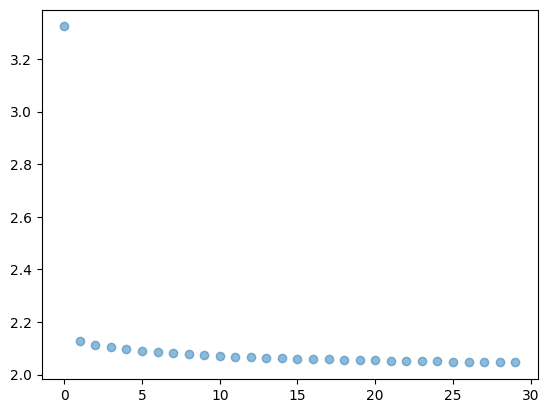

In [21]:
def plot_ts(ys):
    plt.scatter(range(len(ys)), ys, alpha=0.5)

plot_ts([loss(p) for p in ps])

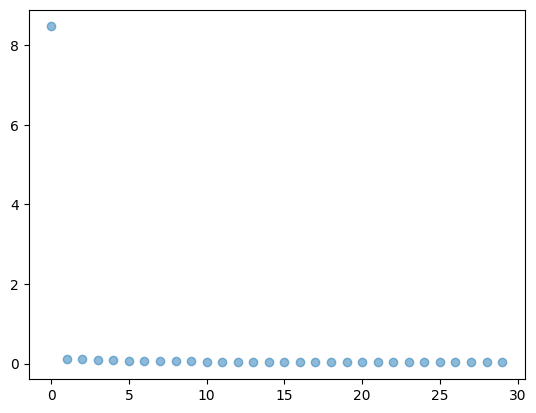

In [22]:
plot_ts([torch.norm(grad_f(p)) for p in ps])

# Comparing Jacobians and Gradients

In [23]:
def pytorch_grad_f(p):
    if p.grad is not None:
        p.grad.zero_()
    loss = f(x(A(B(p))))
    loss.backward()
    return p.grad

def pytorch_jacobian(p):
    """Jacobian: A'(x) = dA / dp"""
    return torch.autograd.functional.jacobian(lambda p: A(B(p)), p) @ dp()    

Anlytical gradients agrees with the pytorch provided one

In [24]:
grad_f(p), pytorch_grad_f(p)

(tensor([ 5.5719,  0.9338,  3.5577, -5.2178,  0.0000], grad_fn=<StackBackward0>),
 tensor([ 5.5719,  0.9338,  3.5577, -5.2178,  0.0000]))

And the analytical jacobian agrees with a pytorch computed one:

In [25]:
APrime_full(p)

Calling dp()


tensor([[ 1.2476e-05, -1.3073e-04,  1.2476e-05, -1.3073e-04],
        [ 2.7472e-05,  4.6230e-05,  2.7472e-05,  4.6230e-05],
        [ 1.2476e-05, -1.3073e-04,  1.2476e-05, -1.3073e-04],
        [ 2.7472e-05,  4.6230e-05,  2.7472e-05,  4.6230e-05]],
       grad_fn=<AddBackward0>)

In [26]:
pytorch_jacobian(p)

Calling dp()


tensor([[ 1.2476e-05, -1.3073e-04,  1.2476e-05, -1.3073e-04],
        [ 2.7472e-05,  4.6230e-05,  2.7472e-05,  4.6230e-05],
        [ 1.2476e-05, -1.3073e-04,  1.2476e-05, -1.3073e-04],
        [ 2.7472e-05,  4.6230e-05,  2.7472e-05,  4.6230e-05]])